In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math

torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib inline

In [2]:
#Unsupervised Learning
class PendulumNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(PendulumNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        X = torch.sin(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))
        
        X = self.out(X)
        return X


In [3]:
m = 1.
L = 1.
g = 1.
T = 30.

theta0 = math.pi/6
p0 = 1
H0 = p0**2/(2*m*L**2) + m*g*L*(1 - np.cos(theta0))

model_pendulum = PendulumNet(1, 64, 2)

#model_pendulum_p = PendulumNet(1, 64, 1)


In [4]:
num_epochs = 500
batch_size = 50
n_train = 1000
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pendulum.parameters(), lr = learning_rate, weight_decay=1e-5)
#optimizer_p = torch.optim.Adam(model_pendulum_p.parameters(), lr=learning_rate, weight_decay=1e-5)


epoch [1/500], loss eqns of motion:1.33622215


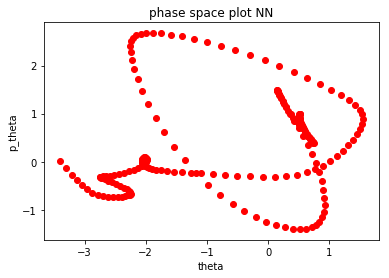

epoch [50/500], loss eqns of motion:0.03023332


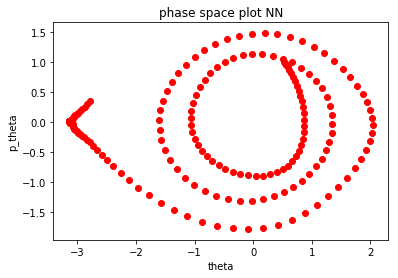

epoch [100/500], loss eqns of motion:0.01891702


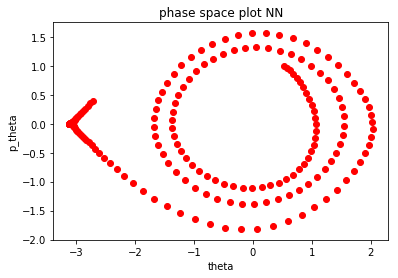

epoch [150/500], loss eqns of motion:0.00626977


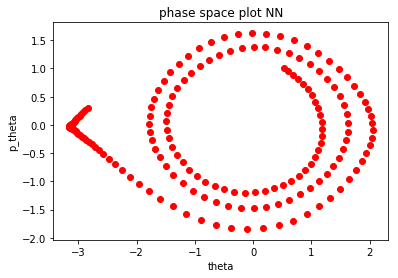

epoch [200/500], loss eqns of motion:0.00538524


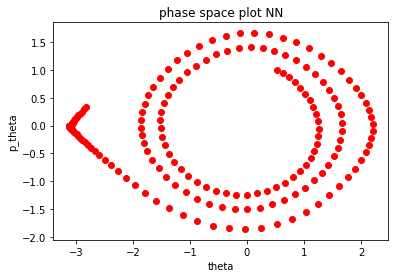

epoch [250/500], loss eqns of motion:0.00269088


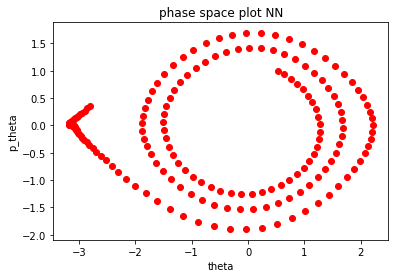

epoch [300/500], loss eqns of motion:0.00262515


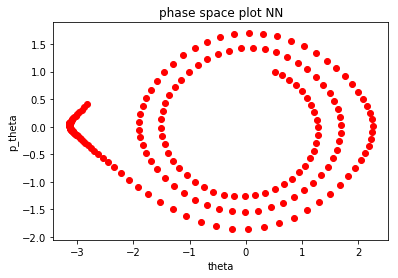

epoch [350/500], loss eqns of motion:0.00352065


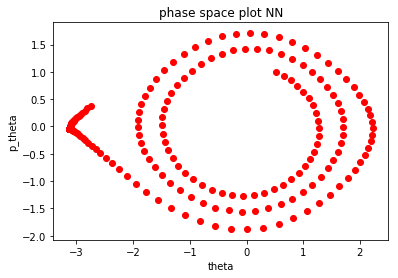

epoch [400/500], loss eqns of motion:0.00298316


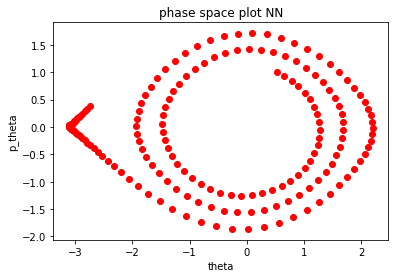

epoch [450/500], loss eqns of motion:0.00245319


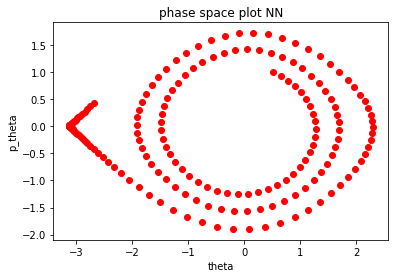

epoch [500/500], loss eqns of motion:0.00295884


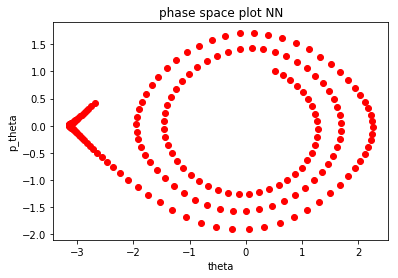

In [73]:
regularize_energy = False
# Start training
for epoch in range(num_epochs):
    tt = np.random.uniform(0, T, n_train)
    #tt = np.random.power(1.5, size = n_train) * T
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    for i in range(int(len(tt)/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta0 + model_pendulum(tti)[:,0].clone().reshape(-1,1) * tti
        p = p0 + model_pendulum(tti)[:,1].clone().reshape(-1,1) * tti
        
        #p = p0 + model_pendulum_p(tti)[:,0].clone().reshape(-1,1) * tti
        
        p.retain_grad()
        theta.retain_grad()

        #H = Hamiltonian_single_pendulum(theta, p)
        H = p**2/(2*m*L**2) + m*g*L*(1 - torch.cos(theta))
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_p, = torch.autograd.grad(H, p, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_d_t, = torch.autograd.grad(p, tti, p.new(p.shape).fill_(1),create_graph = True)
        
        loss_eqn = criterion(d_p_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p)
        
        if(regularize_energy == True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
            
        else:
            loss = loss_eqn

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        
  
    if( (epoch+1) % (num_epochs/10) ==0 or epoch==0):
        print('epoch [{}/{}], loss eqns of motion:{:.8f}'.format(epoch + 1, num_epochs, loss_eqn.data))
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.8f}'.format(epoch + 1, num_epochs, loss_energy.data))

        Nstep = n_train
        tt = np.arange(Nstep+1) * T/Nstep
        tt = torch.Tensor(tt.reshape(-1,1))

        theta =  theta0 + model_pendulum(tt)[:,0].clone().reshape(-1,1)*tt
        p = p0 + model_pendulum(tt)[:,1].clone().reshape(-1,1)*tt
        #p = p0 + model_pendulum_p(tt)[:,0].clone().reshape(-1,1) * tt

        skip = 5

        plt.figure()
        plt.title('phase space plot NN')
        plt.xlabel('theta')
        plt.ylabel('p_theta')
        plt.scatter(theta.detach().numpy()[::skip], p.detach().numpy()[::skip],color = 'r')
        plt.show()

In [5]:
model_pendulum_seq = PendulumNet(1, 64, 2)


In [6]:
#model_pendulum_p = PendulumNet(1, 64, 1)
num_epochs = 500
batch_size = 50
n_train = 1000
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pendulum_seq.parameters(), lr = learning_rate, weight_decay=1e-5)
#optimizer_p = torch.optim.Adam(model_pendulum_p.parameters(), lr=learning_rate, weight_decay=1e-5)


epoch [50/500], loss eqns of motion:0.00040935


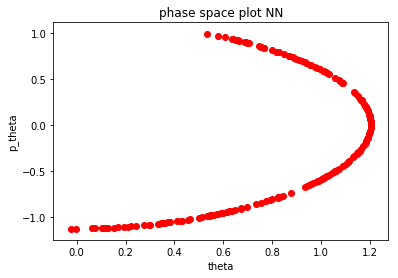

KeyboardInterrupt: 

In [7]:
regularize_energy = False
# Start training
batches = 20
tbatch_size = num_epochs/batches

for epoch in range(num_epochs):
    tbatch = T/batches
    batchNum = int(epoch/tbatch_size)
    #tt = np.random.uniform(0, T, n_train) 
    
    tt = np.random.uniform(0, (batchNum+1) * tbatch, n_train)
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    for i in range(int(len(tt)/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta0 + model_pendulum_seq(tti)[:,0].clone().reshape(-1,1) * tti
        p = p0 + model_pendulum_seq(tti)[:,1].clone().reshape(-1,1) * tti
        
        
        p.retain_grad()
        theta.retain_grad()

        #H = Hamiltonian_single_pendulum(theta, p)
        H = p**2/(2*m*L**2) + m*g*L*(1 - torch.cos(theta))
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_p, = torch.autograd.grad(H, p, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_d_t, = torch.autograd.grad(p, tti, p.new(p.shape).fill_(1),create_graph = True)
        
        loss_eqn = criterion(d_p_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p)
        
        if(regularize_energy == True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
            
        else:
            loss = loss_eqn

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        
  
    if( (epoch+1) % (num_epochs/10) ==0):
        print('epoch [{}/{}], loss eqns of motion:{:.8f}'.format(epoch + 1, num_epochs, loss_eqn.data))
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.8f}'.format(epoch + 1, num_epochs, loss_energy.data))

        Nstep = n_train
        #tt = np.arange(Nstep+1) * T/Nstep
        tt = np.random.uniform(0, (batchNum+1) * tbatch, n_train)
        tt = torch.Tensor(tt.reshape(-1,1))

        theta =  theta0 + model_pendulum_seq(tt)[:,0].clone().reshape(-1,1)*tt
        p = p0 + model_pendulum_seq(tt)[:,1].clone().reshape(-1,1)*tt

        skip = 5

        plt.figure()
        plt.title('phase space plot NN')
        plt.xlabel('theta')
        plt.ylabel('p_theta')
        plt.scatter(theta.detach().numpy()[::skip], p.detach().numpy()[::skip],color = 'r')
        plt.show()

# Spring Pendulum System

In [156]:
m = 1.
L = 1.
g = 1.
k = 1.
T = 25

theta_0 = math.pi/10
p_theta_0 = 0.1
x_0 = -0.02
p_x_0 = 0.

In [157]:
# Same as Pendulum Net..
class SpringPendulumNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(SpringPendulumNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        
        X = torch.sin(self.input(X))
        X = torch.sin(self.fc1(X))
        X = torch.sin(self.fc2(X))
        X = self.out(X)
        return X




In [158]:
model_spring_pendulum = SpringPendulumNet(1, 32, 4)

In [159]:
num_epochs = 1000
n_train0 = 500
minibatches = 10
batch_size = int(n_train0/minibatches)
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_spring_pendulum.parameters(), lr=learning_rate, weight_decay=1e-5)
#optimizer_p = torch.optim.Adam(model_pendulum_p.parameters(), lr=learning_rate, weight_decay=1e-5)


epoch [100/1000], loss Hamiltons equations:0.00191906
epoch [100/1000], loss energy:2.42164243


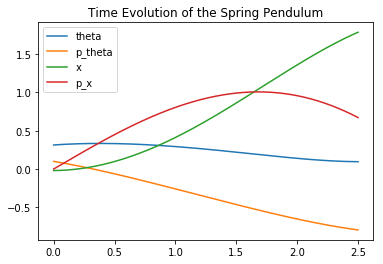

epoch [200/1000], loss Hamiltons equations:0.00071472
epoch [200/1000], loss energy:2.48975361


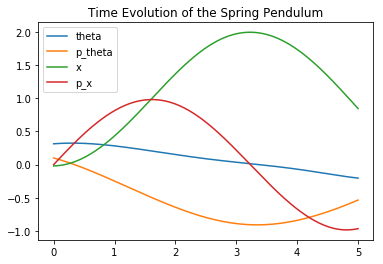

epoch [300/1000], loss Hamiltons equations:0.00147971
epoch [300/1000], loss energy:2.50708971


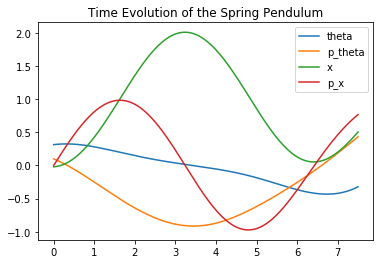

epoch [400/1000], loss Hamiltons equations:0.00283199
epoch [400/1000], loss energy:2.30341345


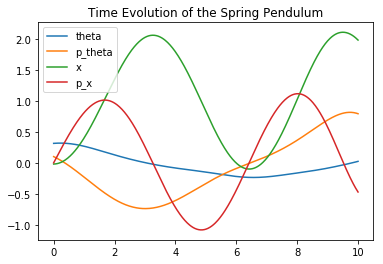

epoch [500/1000], loss Hamiltons equations:0.00056744
epoch [500/1000], loss energy:2.46722752


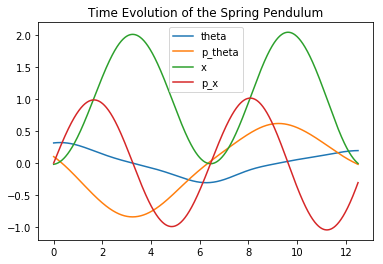

epoch [600/1000], loss Hamiltons equations:0.00091780
epoch [600/1000], loss energy:2.48614955


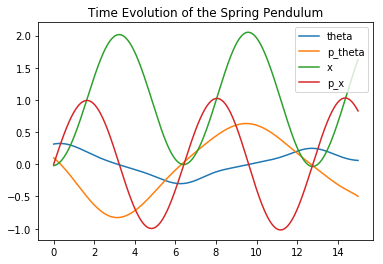

epoch [700/1000], loss Hamiltons equations:0.00057894
epoch [700/1000], loss energy:2.44955346


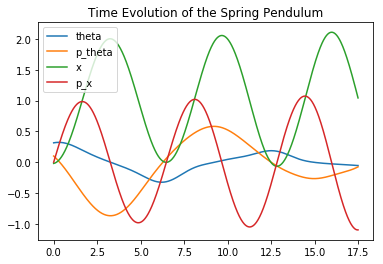

epoch [800/1000], loss Hamiltons equations:0.00086073
epoch [800/1000], loss energy:2.56639769


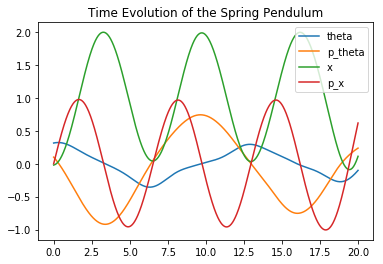

epoch [900/1000], loss Hamiltons equations:0.00092058
epoch [900/1000], loss energy:2.54633012


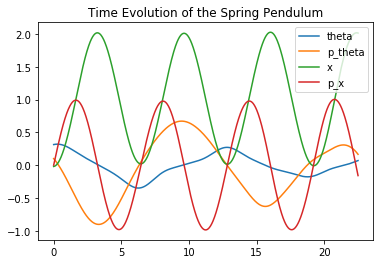

epoch [1000/1000], loss Hamiltons equations:0.00086624
epoch [1000/1000], loss energy:2.43204130


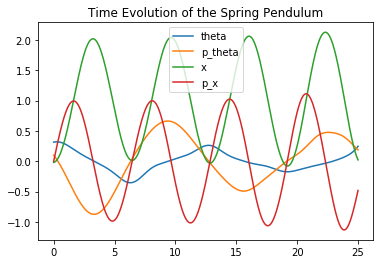

In [160]:
regularize_energy=True

# Start training
tbatches = 40
tbatch_size = num_epochs/tbatches

for epoch in range(num_epochs):
    tbatch = T/tbatches
    batchNum = int(epoch/tbatch_size)
    #tt = np.random.uniform(0, T, n_train) 
    
    n_train = int(np.around(np.exp(batchNum/tbatches)) * n_train0)
    #batch_size = int(n_train/minibatches)
    
    # progressively increase range of t
    tt = np.random.uniform(0, (batchNum+1) * tbatch, n_train)
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)
    
    
    for i in range(int(n_train/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta_0 + model_spring_pendulum(tti)[:,0].clone().reshape(-1,1) * tti
        p_theta = p_theta_0 + model_spring_pendulum(tti)[:,1].clone().reshape(-1,1) * tti
        x = x_0 + model_spring_pendulum(tti)[:,2].clone().reshape(-1,1) * tti
        p_x = p_x_0 + model_spring_pendulum(tti)[:,3].clone().reshape(-1,1) * tti
        
        
        theta.retain_grad()
        p_theta.retain_grad()
        x.retain_grad()
        p_x.retain_grad()
        
        H = 1/2.*m*((p_x/m)**2 + (p_theta/(m*(L+x))) **2 ) - m*g*(L+x)*torch.cos(theta) + 1/2. * k * x**2
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_p_theta, = torch.autograd.grad(H, p_theta, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_x, = torch.autograd.grad(H, x, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_p_x, = torch.autograd.grad(H, p_x, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_theta_d_t, = torch.autograd.grad(p_theta, tti, p_theta.new(p_theta.shape).fill_(1),create_graph = True)
        d_x_d_t, = torch.autograd.grad(x, tti, x.new(x.shape).fill_(1),create_graph = True)
        d_p_x_d_t, = torch.autograd.grad(p_x, tti, p_x.new(p_x.shape).fill_(1),create_graph = True)
        
        loss_eqn = criterion(d_p_theta_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p_theta) + criterion(d_p_x_d_t, - d_H_d_x) + criterion(d_x_d_t, d_H_d_p_x) 
        
        if(regularize_energy==True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
        else:
            loss = loss_eqn
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if( (epoch+1) % (num_epochs/10) ==0):
        print('epoch [{}/{}], loss Hamiltons equations:{:.8f}'.format(epoch + 1, num_epochs, loss_eqn.data))
        
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.8f}'.format(epoch + 1, num_epochs, loss_energy.data))
            
        tt = np.linspace(0, (batchNum+1) * tbatch, n_train)
        #tt = np.sort(tt)
        tt = torch.Tensor(tt.reshape(-1,1))

        theta = theta_0 + model_spring_pendulum(tt)[:,0].clone().reshape(-1,1) * tt
        p_theta = p_theta_0 + model_spring_pendulum(tt)[:,1].clone().reshape(-1,1) * tt
        x = x_0 + model_spring_pendulum(tt)[:,2].clone().reshape(-1,1) * tt
        p_x = p_x_0 + model_spring_pendulum(tt)[:,3].clone().reshape(-1,1) * tt


        plt.figure()
        plt.title('Time Evolution of the Spring Pendulum')

        plt.plot(tt.detach().numpy(), theta.detach().numpy(), label = 'theta')
        plt.plot(tt.detach().numpy(), p_theta.detach().numpy(), label = 'p_theta')
        plt.plot(tt.detach().numpy(), x.detach().numpy(), label = 'x')
        plt.plot(tt.detach().numpy(), p_x.detach().numpy(), label = 'p_x')
        plt.legend()
        plt.show()


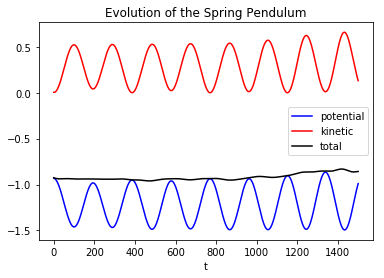

In [162]:
tt = np.arange(n_train+1)*(T/n_train)
tt = torch.Tensor(tt.reshape(-1,1))

theta = theta_0 + model_spring_pendulum(tt)[:,0].clone().reshape(-1,1) * tt
p_theta = p_theta_0 + model_spring_pendulum(tt)[:,1].clone().reshape(-1,1) * tt
x = x_0 + model_spring_pendulum(tt)[:,2].clone().reshape(-1,1) * tt
p_x = p_x_0 + model_spring_pendulum(tt)[:,3].clone().reshape(-1,1) * tt



potential = 1/2.*k* (x.detach().numpy())**2 - m*g*(L+x.detach().numpy()) * np.cos(theta.detach().numpy())
kinetic = 1/2.*m*((p_x.detach().numpy()/m)**2+ (p_theta.detach().numpy()/((L+x.detach().numpy())*m)) **2 )

total = potential + kinetic

plt.figure()
plt.title('Evolution of the Spring Pendulum')

plt.plot(potential,color = 'b', label = 'potential')
plt.plot(kinetic, color = 'r', label = 'kinetic')
plt.plot(total, color = 'k', label = 'total')
plt.xlabel('t')
plt.legend()